# Section 1.4.2.1
Normal random numbers

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st

In [2]:
# suppress some warnings from pymc3 output
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [3]:
%matplotlib inline

The data set has been downloaded from https://www.itl.nist.gov/div898/handbook/datasets/RANDN.DAT

In [4]:
# load data from file as 1d array
filename = 'RANDN.DAT'
data = (np.loadtxt(filename,skiprows=25)).flatten()

In [5]:
N=len(data);
print(N)

500


In [6]:
data[:5] # first five data points

array([-1.276, -1.218, -0.453, -0.35 ,  0.723])

Check some summary statistics to see if they agree.  The published mean in -0.00294 and the published standard deviation is 1.021042.

In [7]:
data.mean()

-0.002936

In [8]:
data.std(ddof=1) # ddof=1 gives sample deviation instead of population deviation (ddof=0).

1.0210411813889704

Reproduce the plots in the source to check for consistency

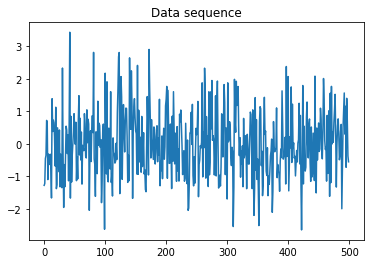

In [9]:
plt.plot(data)
plt.title('Data sequence');

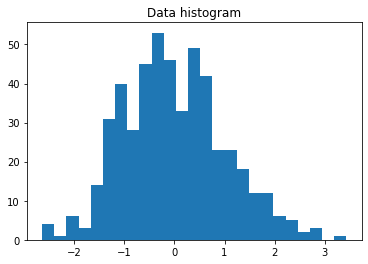

In [10]:
plt.hist(data,bins=25)
plt.title('Data histogram');

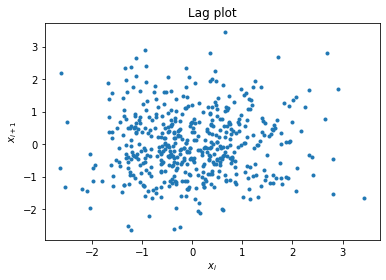

In [11]:
plt.plot(data[:-1],data[1:],'.')
plt.xlabel('$x_i$');
plt.ylabel('$x_{i+1}$')
plt.title('Lag plot');

## Posterior of the mean, assuming fixed variance

Since the data are nominally normally distributed, if we assume a flat prior, analytically we'll get a posterior of
$$
p(\theta|y) \approx N(\theta,\bar{y},\sigma^2/n)
$$
(ref. Gelman pg 52)

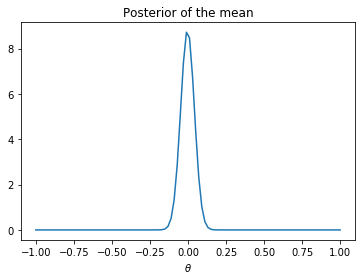

In [12]:
x = np.linspace(-1,1,100)
plt.plot(x,st.norm.pdf(x,data.mean(),np.sqrt(data.std(ddof=1)/N)))
plt.title('Posterior of the mean')
plt.xlabel(r'$ \theta $');

### Model using MCMC

In [13]:
import pymc3 as pm

In [14]:
with pm.Model() as model1:
    theta = pm.Flat('theta')
    sigma = data.std(ddof=1)
    yobs = pm.Normal('yobs',mu=theta,sigma=sigma,observed=data)

In [15]:
with model1:
    trace1=pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta]
Sampling 4 chains: 100%|██████████| 6000/6000 [00:01<00:00, 4660.79draws/s]


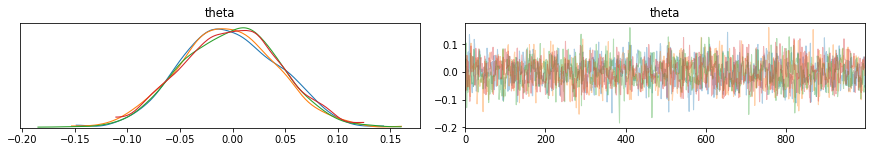

In [16]:
pm.traceplot(trace1);

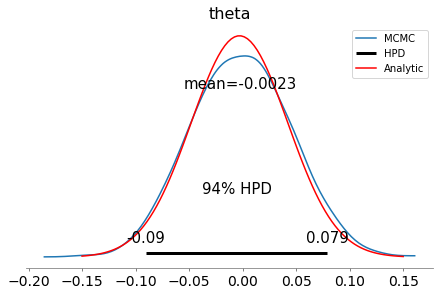

In [17]:
# Compare numerical results to analytic results
pm.plot_posterior(trace1)
x = np.linspace(-0.15,0.15,100)
plt.plot(x,st.norm.pdf(x,data.mean(),np.sqrt(data.std(ddof=1)/N)),'r')
plt.legend(['MCMC','HPD','Analytic']);

### TODOs
* Run again without fixed sigma
* Add linear drift and compare the fixed mean model with linear drift model
* Compare to Gaussian Process model